# Introduction: Run file ini di google colab soalnya masih belom ngerti kalo deploy di vs code gimana

In [ ]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q scann
!apt-get install tensorflow-model-server

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Text
import os
import requests
import json
import tempfile

import tensorflow_recommenders as tfrs
import tensorflow_datasets as tfds

# Load Data dan Dirubah jadi tf tensor

- Load data pake read csv terus diubah ke tensor pake from tensor slices
- Split training dan validation set 80:20
- Mengambil nama unik penyakit, user id, dan makanan

In [2]:
user_profile_df = pd.read_csv('dataset\\user_activities.csv')
foods_df = pd.read_csv('dataset\\dataset.csv')
user_profile_df = user_profile_df[['User_Id','Disease','food_name']]
foods_df = foods_df.drop(['description','Price'],axis=1)
user_profile_ds = tf.data.Dataset.from_tensor_slices(dict(user_profile_df))
foods_ds = tf.data.Dataset.from_tensor_slices(dict(foods_df))

In [3]:
foods_ds = foods_ds.map(lambda x: x["Name"])

In [4]:
tf.random.set_seed(42)
shuffled = user_profile_ds.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.take(20_000)

In [ ]:
food_names = foods_ds.batch(20)
user_names = user_profile_ds.batch(20).map(lambda x: x['User_Id'])
disease_names = user_profile_ds.batch(20).map(lambda x: x['Disease'])
#for tensor in list(disease_names):
    #print(tensor)
unique_food_names = np.unique(np.concatenate(list(food_names)))
unique_user_names = np.unique(np.concatenate(list(user_names)))
unique_disease_names = np.unique(np.concatenate(list(disease_names)))

unique_user_names[:100]

# Membuat Model

- Membuat user model yang mengambil input user id dan penyakit
- Membuat food model yang mengambil input makanan
- Membuat kelas query model yang akan menampung user model dan menambahkan hidden layer
- Membuat candidate model yang akan menampung food model dan menambahkan hidden layer
- Membuat kelas foodrecmodel untuk menggambungkan kedua model 

In [6]:
embedding_dimension = 32

In [7]:
class UserModel(tf.keras.Model):
    def __init__(self):
        super().__init__()

        max_tokens = 1000
        self.user_embedding = tf.keras.Sequential([
         tf.keras.layers.StringLookup(vocabulary= unique_user_names, mask_token=None),
         tf.keras.layers.Embedding(len(unique_user_names)+1, embedding_dimension)
    ])
        self.disease_embedding = tf.keras.Sequential([
         tf.keras.layers.StringLookup(vocabulary= unique_disease_names, mask_token=None),
         tf.keras.layers.Embedding(len(unique_disease_names)+1, embedding_dimension)
        ])
        self.disease_vector = tf.keras.layers.TextVectorization(max_tokens=max_tokens)

        self.disease_text_embedding = tf.keras.Sequential([
         self.disease_vector,
         tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
      # We average the embedding of individual words to get one embedding vector
      # per title.
         tf.keras.layers.GlobalAveragePooling1D()
    ])
        self.disease_vector.adapt(user_profile_ds.map(lambda x: x['Disease']))

    def call(self, inputs):
        return tf.concat([
            self.user_embedding(inputs['User_Id']),
            self.disease_embedding(inputs['Disease']),
            self.disease_text_embedding(inputs['Disease']),
        ], axis=1)

In [8]:
class FoodModel(tf.keras.Model):
    def __init__(self):
        super().__init__()

        max_tokens = 1000
        self.food_embedding = tf.keras.Sequential([
         tf.keras.layers.StringLookup(vocabulary= unique_food_names, mask_token=None),
         tf.keras.layers.Embedding(len(unique_food_names)+1, embedding_dimension)
    ])
        '''self.disease_embedding = tf.keras.Sequential([
         tf.keras.layers.TextVectorization(max_tokens=max_tokens),
         tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
      # We average the embedding of individual words to get one embedding vector
      # per title.
         tf.keras.layers.GlobalAveragePooling1D()
    ])'''

    def call(self, titles):
        return tf.concat([
            self.food_embedding(titles),
            #self.disease_embedding(inputs['Disease']),
        ], axis=1)

In [9]:
class QueryModel(tf.keras.Model):
    def __init__(self, layer_sizes):
        super().__init__()

        self.embedding_model= UserModel()

        self.dense_layers = tf.keras.Sequential()

        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    # No activation for the last layer.
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))

    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

In [10]:
class CandidateModel(tf.keras.Model):
    def __init__(self, layer_sizes):
        super().__init__()

        self.embedding_model = FoodModel()
        self.dense_layers = tf.keras.Sequential()
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    # No activation for the last layer.
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))

    def call(self, titles):
        feature_embedding = self.embedding_model(titles)
        return self.dense_layers(feature_embedding)

In [11]:
class FoodRecModel(tfrs.models.Model):
    def __init__(self, layer_sizes):
        super().__init__()
        self.query_model = QueryModel(layer_sizes)
        self.candidate_model = CandidateModel(layer_sizes)
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=foods_ds.batch(20).map(self.candidate_model),
            ),
        )
    
    def compute_loss(self, features, training=False):
        query_embeddings = self.query_model({
            "User_Id": features['User_Id'],
            "Disease": features['Disease'],
        })
        food_embeddings = self.candidate_model(features['food_name'])

        return self.task(query_embeddings, food_embeddings, compute_metrics=not training)

# Training Model

- Membuat perbandingan model dengan satu layer dan dua layer

In [12]:
cached_train = train.shuffle(100_000).batch(5).cache()
cached_test = test.batch(5).cache()

In [13]:
num_epochs = 25

model = FoodRecModel([32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.2))

In [14]:
one_layer_history = model.fit(cached_train, epochs=num_epochs, validation_data=cached_test, validation_freq=5)

Epoch 1/25
21/21 [==============================] - 2s 6ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 7.2158 - regularization_loss: 0.0000e+00 - total_loss: 7.2158
Epoch 2/25
21/21 [==============================] - 0s 6ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6.5471 - regularization_loss: 0.0000e+00 - total_loss: 6.5471
Epoch 3/25
21/21 [==============================] - 0s 7ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top

In [15]:
accuracy = one_layer_history.history["val_factorized_top_k/top_10_categorical_accuracy"][-1]
print(f"Top-10 accuracy: {accuracy:.10f}.")

Top-10 accuracy: 0.9603960514.


In [30]:
model = FoodRecModel([64, 32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

two_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

accuracy = two_layer_history.history["val_factorized_top_k/top_5_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

Top-100 accuracy: 0.56.


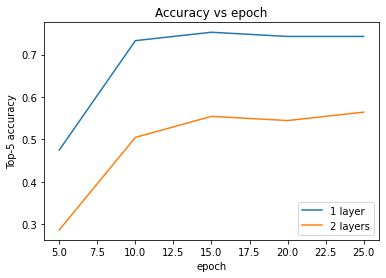

In [31]:
num_validation_runs = len(one_layer_history.history["val_factorized_top_k/top_5_categorical_accuracy"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.plot(epochs, one_layer_history.history["val_factorized_top_k/top_5_categorical_accuracy"], label="1 layer")
plt.plot(epochs, two_layer_history.history["val_factorized_top_k/top_5_categorical_accuracy"], label="2 layers")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-5 accuracy");
plt.legend()

In [16]:
model.evaluate(cached_test, return_dict=True)

21/21 [==============================] - 3s 141ms/step - factorized_top_k/top_1_categorical_accuracy: 0.2079 - factorized_top_k/top_5_categorical_accuracy: 0.6832 - factorized_top_k/top_10_categorical_accuracy: 0.9604 - factorized_top_k/top_50_categorical_accuracy: 0.9901 - factorized_top_k/top_100_categorical_accuracy: 0.9901 - loss: 1.8673 - regularization_loss: 0.0000e+00 - total_loss: 1.8673


{'factorized_top_k/top_1_categorical_accuracy': 0.20792078971862793,
 'factorized_top_k/top_5_categorical_accuracy': 0.6831682920455933,
 'factorized_top_k/top_10_categorical_accuracy': 0.9603960514068604,
 'factorized_top_k/top_50_categorical_accuracy': 0.9900990128517151,
 'factorized_top_k/top_100_categorical_accuracy': 0.9900990128517151,
 'loss': 0.0,
 'regularization_loss': 0,
 'total_loss': 0.0}

# Prediksi

- Membuat layer baru dengan nama variabel index yang akan digunakan untuk memprediksi dan juga untuk dideploy

In [17]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.query_model)
index.index_from_dataset(
  foods_ds.batch(20).map(lambda  name: (name, model.candidate_model(name)))
)

In [18]:
_, diets = index({
    "User_Id": np.array(['User_80']),
    "Disease": np.array(['anemia'])
})
print(f"Top 10 recommendation for Disease: {diets[0, :20]}")

Top 10 recommendation for Disease: [b'banana walnut smoothie' b'green asparagus risotto'
 b'moong dal kiwi coconut soup' b'oyster lamb'
 b'couscous with ratatouille - tangy tomato sauce'
 b'baked shankarpali recipe' b'chocolate appo'
 b'almond and cranberry poha' b'green cucumber shots' b'egg paratha']


# Deploy Model

In [19]:
tf.saved_model.save(index, 'model')

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Save model pada direktori yang diinginkan dan diberikan nomor versi

In [49]:
MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))

if os.path.isdir(export_path):
  print("already saved a model")
  !rm -r {export_path}

tf.saved_model.save(index, export_path)
print('\nexport_path = {}'.format(export_path))
!ls -l {export_path}

INFO:tensorflow:Assets written to: /tmp/1/assets


INFO:tensorflow:Assets written to: /tmp/1/assets



export_path = /tmp/1
total 484
drwxr-xr-x 2 root root   4096 Jun  5 13:26 assets
-rw-r--r-- 1 root root 486488 Jun  5 13:26 saved_model.pb
drwxr-xr-x 2 root root   4096 Jun  5 13:26 variables


In [50]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['Disease'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: serving_default_Disease:0
    inputs['User_Id'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: serving_default_User_Id:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['output_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall_3:0
    outputs['output_2'] tensor_info:
        dtype: DT_STRING
 

Deploy model dengan tf serving

In [51]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [52]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=foodrec \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [53]:
!tail server.log

[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 245] NET_LOG: Entering the event loop ...


# Call the Model

- Membuat prediksi dengan memanggil model menggunakan modul requests

In [151]:
xs = np.array(['goitre'])
ys = np.array(['User_80'])
data = json.dumps({"signature_name": "serving_default", "instances": [{"Disease": 'hypertension',
"User_Id": 'User_105'
}]})
print(data)

{"signature_name": "serving_default", "instances": [{"Disease": "hypertension", "User_Id": "User_105"}]}


In [152]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/foodrec:predict', data=data, headers=headers)

print(json_response.text)

{
    "predictions": [
        {
            "output_1": [5.35065556, 5.09741449, 5.08111143, 4.6328373, 4.36994, 4.05344582, 3.8008883, 3.67196918, 3.48455358, 3.44286227],
            "output_2": ["green asparagus risotto", "moong dal kiwi coconut soup", "banana chips", "green cucumber shots", "fried rice with soya chunks", "dahi lasooni chicken", "shepherds salad (tamatar-kheera salaad)", "egg paratha", "prawn and litchi salad", "baked almond kofta"]
        }
    ]
}


In [156]:
predictions = json.loads(json_response.text)['predictions']
print(predictions)

[{'output_1': [5.35065556, 5.09741449, 5.08111143, 4.6328373, 4.36994, 4.05344582, 3.8008883, 3.67196918, 3.48455358, 3.44286227], 'output_2': ['green asparagus risotto', 'moong dal kiwi coconut soup', 'banana chips', 'green cucumber shots', 'fried rice with soya chunks', 'dahi lasooni chicken', 'shepherds salad (tamatar-kheera salaad)', 'egg paratha', 'prawn and litchi salad', 'baked almond kofta']}]
